In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from model_rf import model_wq, retrieve_top_buffer
from plot_xai import calculate_shap, plot_avg_shap, plot_beeswarm_shap, plot_pdps

In [2]:
import warnings
warnings.filterwarnings("ignore", message=".*The figure layout has changed to tight.*")

In [3]:
os.chdir("..")

cwd = os.getcwd()

In [4]:
input_folder = os.path.join(cwd, "input")

output_folder = os.path.join(cwd, "output")

figure_folder = os.path.join(cwd, "output", "figures")

In [5]:
# Set plot color
cmap = sns.diverging_palette(220, 20, as_cmap=True)
plot_tone = cmap(0.0)

# 1. Retrieve the TOP covariates

In [6]:
preds_tn = pd.read_csv(f'{input_folder}\\covariates_tn.csv')

In [7]:
preds_tn

,site_id,bdod_mean,clay_mean,clay_std,dem_mean,dem_std,slope_mean,flow_acc_mean,dist_from_streams_mean,grassland,...,built_up,water,wetland,other,meantemp_mean,totprecip_mean,meantemp_std,totprecip_std,livestock_mean,livestock_std
0,ee_SJA0088000,0.65,16.15,4.94,39.36,18.11,3.83,1.92,322.53,11.58,...,0.11,0.42,6.58,0.5,7.2,789.0,0.1,13.0,3.13,1.60
1,ee_SJA0106000,0.64,14.51,1.15,61.33,6.78,3.14,0.34,356.11,17.33,...,0.19,0.16,0.16,0.1,6.8,713.0,0.1,3.0,17.81,1.49
2,ee_SJA0112000,0.65,13.10,1.51,92.82,15.55,3.90,0.55,370.43,20.50,...,0.13,0.31,0.18,0.4,6.8,759.0,0.0,3.0,7.02,1.45
3,ee_SJA0135000,0.63,14.98,1.75,90.99,15.26,3.12,2.19,352.85,10.99,...,0.18,0.10,5.11,0.7,6.5,760.0,0.1,8.0,15.08,7.87
4,ee_SJA0148000,0.64,16.08,4.46,56.89,23.92,3.82,6.09,337.64,13.94,...,0.34,0.30,4.89,0.8,6.9,766.0,0.2,20.0,8.21,6.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,lt_666,0.99,16.73,0.85,20.11,9.92,3.14,0.47,356.89,21.70,...,0.56,0.67,0.11,0.6,9.0,782.0,0.1,16.0,9.60,0.54
889,lt_667,0.90,12.67,1.37,121.38,13.19,4.03,0.58,369.15,20.23,...,0.40,0.07,0.16,0.3,8.3,761.0,0.0,2.0,9.90,2.24
890,lt_668,0.93,15.52,1.08,66.35,11.28,2.53,0.43,316.63,17.06,...,0.53,0.09,0.01,0.2,8.8,710.0,0.1,2.0,17.13,1.52
891,lt_669,0.85,9.48,1.00,151.39,13.76,4.55,0.67,314.93,12.28,...,0.43,3.66,1.01,0.2,8.2,768.0,0.0,1.0,5.52,1.58


In [8]:
top_tn = pd.read_csv(f'{output_folder}\\top_5_tn.csv')

top_tn

,Unnamed: 0,feature,importance
0,9,cropland,1.570646
1,8,grassland,0.215956
2,15,totprecip_mean,0.213329
3,5,slope_mean,0.162598
4,11,water,0.100128


In [9]:
lst = top_tn['feature'].tolist()

lst.append('site_id')

# select the top 5 covariates
preds_tn = preds_tn[lst]

In [10]:
tn = pd.read_csv(f'{input_folder}\\tn.csv')

In [11]:
# join the prediction targets
preds_tn =  pd.merge(tn, preds_tn, on = 'site_id', how = 'left')
preds_tn

,site_id,value,X,Y,cropland,grassland,totprecip_mean,slope_mean,water
0,ee_SJA0088000,1.39,6.460567e+06,536966.995615,6.81,11.58,789.0,3.83,0.42
1,ee_SJA0106000,5.28,6.499463e+06,611096.533002,35.75,17.33,713.0,3.14,0.16
2,ee_SJA0112000,1.27,6.443129e+06,585488.041664,28.81,20.50,759.0,3.90,0.31
3,ee_SJA0135000,4.47,6.565404e+06,582794.408882,26.62,10.99,760.0,3.12,0.10
4,ee_SJA0148000,1.90,6.472192e+06,529013.514162,17.40,13.94,766.0,3.82,0.30
...,...,...,...,...,...,...,...,...,...
888,lv_92,1.57,6.310550e+06,413147.668799,26.67,20.79,743.0,4.07,0.15
889,lv_94,1.70,6.319852e+06,416381.110931,29.71,20.71,742.0,3.95,0.18
890,lv_95,1.66,6.192672e+06,710175.286098,29.45,18.03,785.0,4.28,1.96
891,lv_97,1.09,6.380848e+06,372416.139786,7.12,15.02,736.0,4.64,2.59


In [12]:
preds_tp = pd.read_csv(f'{input_folder}\\covariates_tp.csv')

In [13]:
top_tp = pd.read_csv(f'{output_folder}\\top_5_tp.csv')

In [14]:
lst = top_tp['feature'].tolist()

lst.append('site_id')

preds_tp = preds_tp[lst]

In [15]:
tp = pd.read_csv(f'{input_folder}\\tp.csv')

In [16]:
preds_tp =  pd.merge(tp, preds_tp, on = 'site_id', how = 'left')
preds_tp

,site_id,value,X,Y,built_up,cropland,meantemp_mean,clay_std,stream_density
0,ee_SJA0088000,0.050,6.460567e+06,536966.995615,0.11,6.81,7.2,4.94,1.01
1,ee_SJA0106000,0.021,6.499463e+06,611096.533002,0.19,35.75,6.8,1.15,1.12
2,ee_SJA0112000,0.036,6.443129e+06,585488.041664,0.13,28.81,6.8,1.51,0.87
3,ee_SJA0135000,0.028,6.565404e+06,582794.408882,0.18,26.62,6.5,1.75,0.98
4,ee_SJA0148000,0.050,6.472192e+06,529013.514162,0.34,17.40,6.9,4.46,1.00
...,...,...,...,...,...,...,...,...,...
888,lv_92,0.043,6.310550e+06,413147.668799,0.15,26.67,7.7,2.23,0.96
889,lv_94,0.026,6.319852e+06,416381.110931,0.16,29.71,7.7,2.25,0.97
890,lv_95,0.020,6.192672e+06,710175.286098,0.10,29.45,7.3,2.10,0.94
891,lv_97,0.043,6.380848e+06,372416.139786,0.22,7.12,8.2,2.23,0.97


# 2. TN XY model

In [17]:
xy_tn_model, xy_tn_X_train = model_wq(preds_tn, 'tn', 'coordinate', output_folder)

RF model for tn
Splitting data for tn
Covariates used:  X, Y, cropland, grassland, totprecip_mean, slope_mean, water
Tuning hyperparameters for tn
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END ......max_depth=5, n_estimators=50;, score=0.784 total time=   0.1s
[CV 2/5] END ......max_depth=5, n_estimators=50;, score=0.731 total time=   0.1s
[CV 3/5] END ......max_depth=5, n_estimators=50;, score=0.729 total time=   0.1s
[CV 4/5] END ......max_depth=5, n_estimators=50;, score=0.653 total time=   0.0s
[CV 5/5] END ......max_depth=5, n_estimators=50;, score=0.826 total time=   0.1s
[CV 1/5] END ......max_depth=5, n_estimators=60;, score=0.785 total time=   0.1s
[CV 2/5] END ......max_depth=5, n_estimators=60;, score=0.733 total time=   0.1s
[CV 3/5] END ......max_depth=5, n_estimators=60;, score=0.733 total time=   0.1s
[CV 4/5] END ......max_depth=5, n_estimators=60;, score=0.656 total time=   0.1s
[CV 5/5] END ......max_depth=5, n_estimators=60;, score=0.826 

In [18]:
xy_tn_shap_values = calculate_shap(xy_tn_model, xy_tn_X_train)

plot_avg_shap(xy_tn_shap_values, xy_tn_X_train, figure_folder, 'no output')

No figure created


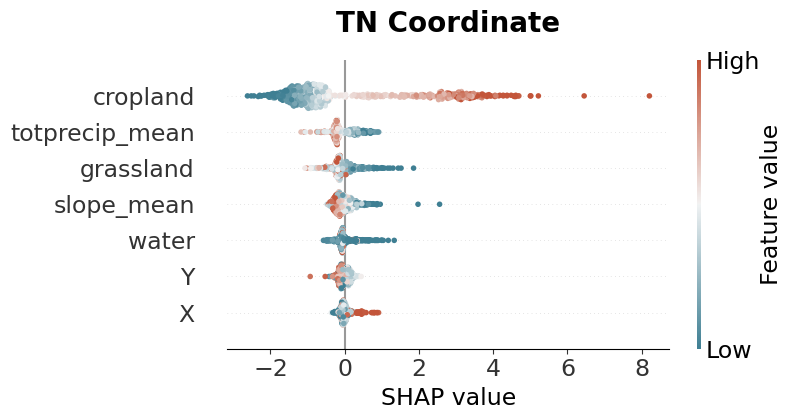

In [19]:
plot_beeswarm_shap(xy_tn_shap_values, xy_tn_X_train, figure_folder, 'tn',  'coordinate', 'Figure_6c')

In [20]:
plot_pdps(xy_tn_model, xy_tn_X_train, figure_folder, 'no output')

No figure created


# 3. TP XY model

In [21]:
xy_tp_model, xy_tp_X_train = model_wq(preds_tp, 'tp', 'coordinate', output_folder)

RF model for tp
Splitting data for tp
Covariates used:  X, Y, built_up, cropland, meantemp_mean, clay_std, stream_density
Tuning hyperparameters for tp
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END ......max_depth=5, n_estimators=50;, score=0.252 total time=   0.0s
[CV 2/5] END ......max_depth=5, n_estimators=50;, score=0.210 total time=   0.0s
[CV 3/5] END .....max_depth=5, n_estimators=50;, score=-0.473 total time=   0.0s
[CV 4/5] END ......max_depth=5, n_estimators=50;, score=0.296 total time=   0.0s
[CV 5/5] END ......max_depth=5, n_estimators=50;, score=0.123 total time=   0.0s
[CV 1/5] END ......max_depth=5, n_estimators=60;, score=0.245 total time=   0.1s
[CV 2/5] END ......max_depth=5, n_estimators=60;, score=0.210 total time=   0.1s
[CV 3/5] END .....max_depth=5, n_estimators=60;, score=-0.475 total time=   0.0s
[CV 4/5] END ......max_depth=5, n_estimators=60;, score=0.298 total time=   0.1s
[CV 5/5] END ......max_depth=5, n_estimators=60;, score=0

In [22]:
xy_tp_shap_values = calculate_shap(xy_tp_model, xy_tp_X_train)

plot_avg_shap(xy_tp_shap_values, xy_tp_X_train, figure_folder, 'no output')

No figure created


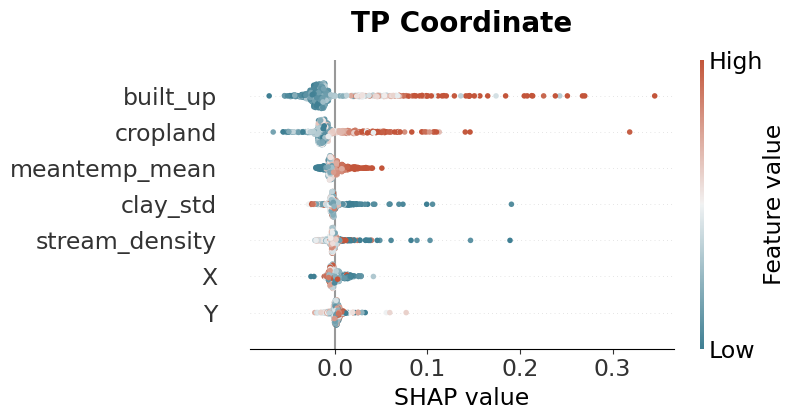

In [23]:
plot_beeswarm_shap(xy_tp_shap_values, xy_tp_X_train,figure_folder,  'tp', 'coordinate', 'Figure_6d')

In [24]:
plot_pdps(xy_tp_model, xy_tp_X_train, figure_folder, 'no output')

No figure created


# 4. Select the predictors for the buffer model

In [25]:
preds_tn_buff = pd.read_csv(f'{input_folder}\\buffered_covariates_tn.csv')
preds_tn_buff

,site_id,cropland_500,cropland_100,grassland_500,grassland_100,totprecip_500_mean,totprecip_100_mean,slope_500_mean,slope_100_mean,water_500,water_100
0,ee_SJA0088000,7.16,6.72,12.10,12.77,790.0,790.0,3.88,3.76,0.46,0.34
1,ee_SJA0106000,29.03,14.32,20.43,21.99,712.0,712.0,3.37,3.55,0.22,0.81
2,ee_SJA0112000,26.72,18.08,21.30,18.01,759.0,759.0,3.90,4.62,0.44,1.41
3,ee_SJA0135000,25.39,23.50,11.66,12.26,760.0,760.0,3.16,3.03,0.13,0.17
4,ee_SJA0148000,16.15,13.40,14.48,15.41,766.0,766.0,3.91,3.90,0.38,1.00
...,...,...,...,...,...,...,...,...,...,...,...
947,lt_666,41.02,48.96,24.58,33.23,783.0,784.0,2.94,1.87,0.57,1.28
948,lt_667,28.85,18.92,22.13,27.32,761.0,761.0,4.10,4.70,0.10,0.28
949,lt_668,61.15,60.42,18.04,18.86,710.0,710.0,2.48,2.43,0.02,0.00
950,lt_669,3.43,3.67,11.99,11.28,768.0,768.0,4.50,4.54,4.66,8.61


In [26]:
preds_tp_buff = pd.read_csv(f'{input_folder}\\buffered_covariates_tp.csv')
preds_tp_buff

,site_id,built_up_500,built_up_100,cropland_500,cropland_100,meantemp_500_mean,meantemp_100_mean,clay_500_std,clay_100_std,stream_density
0,ee_SJA0088000,0.11,0.06,7.16,6.72,7.19,7.19,4.895191,4.870406,1.01
1,ee_SJA0106000,0.19,0.00,29.03,14.32,6.83,6.84,1.225414,1.259074,1.12
2,ee_SJA0112000,0.18,0.03,26.72,18.08,6.78,6.78,1.585770,1.608365,0.87
3,ee_SJA0135000,0.19,0.12,25.39,23.50,6.46,6.46,1.732483,1.722972,0.98
4,ee_SJA0148000,0.30,0.19,16.15,13.40,6.94,6.94,4.447992,4.465162,1.00
...,...,...,...,...,...,...,...,...,...,...
947,lt_666,0.48,0.60,41.02,48.96,8.97,8.98,0.852754,0.956483,0.91
948,lt_667,0.33,0.06,28.85,18.92,8.31,8.31,1.378721,1.462087,0.88
949,lt_668,0.64,0.41,61.15,60.42,8.84,8.84,1.084211,1.059309,0.99
950,lt_669,0.06,0.01,3.43,3.67,8.21,8.21,1.011522,0.966659,1.00


In [27]:
preds_tn

,site_id,value,X,Y,cropland,grassland,totprecip_mean,slope_mean,water
0,ee_SJA0088000,1.39,6.460567e+06,536966.995615,6.81,11.58,789.0,3.83,0.42
1,ee_SJA0106000,5.28,6.499463e+06,611096.533002,35.75,17.33,713.0,3.14,0.16
2,ee_SJA0112000,1.27,6.443129e+06,585488.041664,28.81,20.50,759.0,3.90,0.31
3,ee_SJA0135000,4.47,6.565404e+06,582794.408882,26.62,10.99,760.0,3.12,0.10
4,ee_SJA0148000,1.90,6.472192e+06,529013.514162,17.40,13.94,766.0,3.82,0.30
...,...,...,...,...,...,...,...,...,...
888,lv_92,1.57,6.310550e+06,413147.668799,26.67,20.79,743.0,4.07,0.15
889,lv_94,1.70,6.319852e+06,416381.110931,29.71,20.71,742.0,3.95,0.18
890,lv_95,1.66,6.192672e+06,710175.286098,29.45,18.03,785.0,4.28,1.96
891,lv_97,1.09,6.380848e+06,372416.139786,7.12,15.02,736.0,4.64,2.59


In [28]:
# add buffered covariates to the full-catchment ones (we need both)
tn =  pd.merge(preds_tn, preds_tn_buff, on = 'site_id', how = 'inner')
tn

,site_id,value,X,Y,cropland,grassland,totprecip_mean,slope_mean,water,cropland_500,cropland_100,grassland_500,grassland_100,totprecip_500_mean,totprecip_100_mean,slope_500_mean,slope_100_mean,water_500,water_100
0,ee_SJA0088000,1.39,6.460567e+06,536966.995615,6.81,11.58,789.0,3.83,0.42,7.16,6.72,12.10,12.77,790.0,790.0,3.88,3.76,0.46,0.34
1,ee_SJA0106000,5.28,6.499463e+06,611096.533002,35.75,17.33,713.0,3.14,0.16,29.03,14.32,20.43,21.99,712.0,712.0,3.37,3.55,0.22,0.81
2,ee_SJA0112000,1.27,6.443129e+06,585488.041664,28.81,20.50,759.0,3.90,0.31,26.72,18.08,21.30,18.01,759.0,759.0,3.90,4.62,0.44,1.41
3,ee_SJA0135000,4.47,6.565404e+06,582794.408882,26.62,10.99,760.0,3.12,0.10,25.39,23.50,11.66,12.26,760.0,760.0,3.16,3.03,0.13,0.17
4,ee_SJA0148000,1.90,6.472192e+06,529013.514162,17.40,13.94,766.0,3.82,0.30,16.15,13.40,14.48,15.41,766.0,766.0,3.91,3.90,0.38,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,lv_92,1.57,6.310550e+06,413147.668799,26.67,20.79,743.0,4.07,0.15,25.79,19.27,21.97,24.13,743.0,744.0,4.08,4.64,0.20,0.56
889,lv_94,1.70,6.319852e+06,416381.110931,29.71,20.71,742.0,3.95,0.18,27.86,20.37,21.82,23.59,742.0,742.0,4.00,4.67,0.23,0.50
890,lv_95,1.66,6.192672e+06,710175.286098,29.45,18.03,785.0,4.28,1.96,25.88,17.08,17.71,16.44,785.0,785.0,4.42,4.60,2.64,5.95
891,lv_97,1.09,6.380848e+06,372416.139786,7.12,15.02,736.0,4.64,2.59,7.31,7.06,15.88,17.90,736.0,736.0,4.62,4.49,3.16,5.72


In [29]:
tp = pd.merge(preds_tp, preds_tp_buff.drop(columns=['stream_density']), on = 'site_id', how = 'inner')

tp

,site_id,value,X,Y,built_up,cropland,meantemp_mean,clay_std,stream_density,built_up_500,built_up_100,cropland_500,cropland_100,meantemp_500_mean,meantemp_100_mean,clay_500_std,clay_100_std
0,ee_SJA0088000,0.050,6.460567e+06,536966.995615,0.11,6.81,7.2,4.94,1.01,0.11,0.06,7.16,6.72,7.19,7.19,4.895191,4.870406
1,ee_SJA0106000,0.021,6.499463e+06,611096.533002,0.19,35.75,6.8,1.15,1.12,0.19,0.00,29.03,14.32,6.83,6.84,1.225414,1.259074
2,ee_SJA0112000,0.036,6.443129e+06,585488.041664,0.13,28.81,6.8,1.51,0.87,0.18,0.03,26.72,18.08,6.78,6.78,1.585770,1.608365
3,ee_SJA0135000,0.028,6.565404e+06,582794.408882,0.18,26.62,6.5,1.75,0.98,0.19,0.12,25.39,23.50,6.46,6.46,1.732483,1.722972
4,ee_SJA0148000,0.050,6.472192e+06,529013.514162,0.34,17.40,6.9,4.46,1.00,0.30,0.19,16.15,13.40,6.94,6.94,4.447992,4.465162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,lv_92,0.043,6.310550e+06,413147.668799,0.15,26.67,7.7,2.23,0.96,0.13,0.08,25.79,19.27,7.72,7.72,2.181219,2.056682
889,lv_94,0.026,6.319852e+06,416381.110931,0.16,29.71,7.7,2.25,0.97,0.14,0.08,27.86,20.37,7.72,7.72,2.181510,2.061917
890,lv_95,0.020,6.192672e+06,710175.286098,0.10,29.45,7.3,2.10,0.94,0.08,0.06,25.88,17.08,7.31,7.31,2.156291,2.283087
891,lv_97,0.043,6.380848e+06,372416.139786,0.22,7.12,8.2,2.23,0.97,0.20,0.13,7.31,7.06,8.16,8.16,2.253273,2.284595


<Figure size 900x900 with 0 Axes>

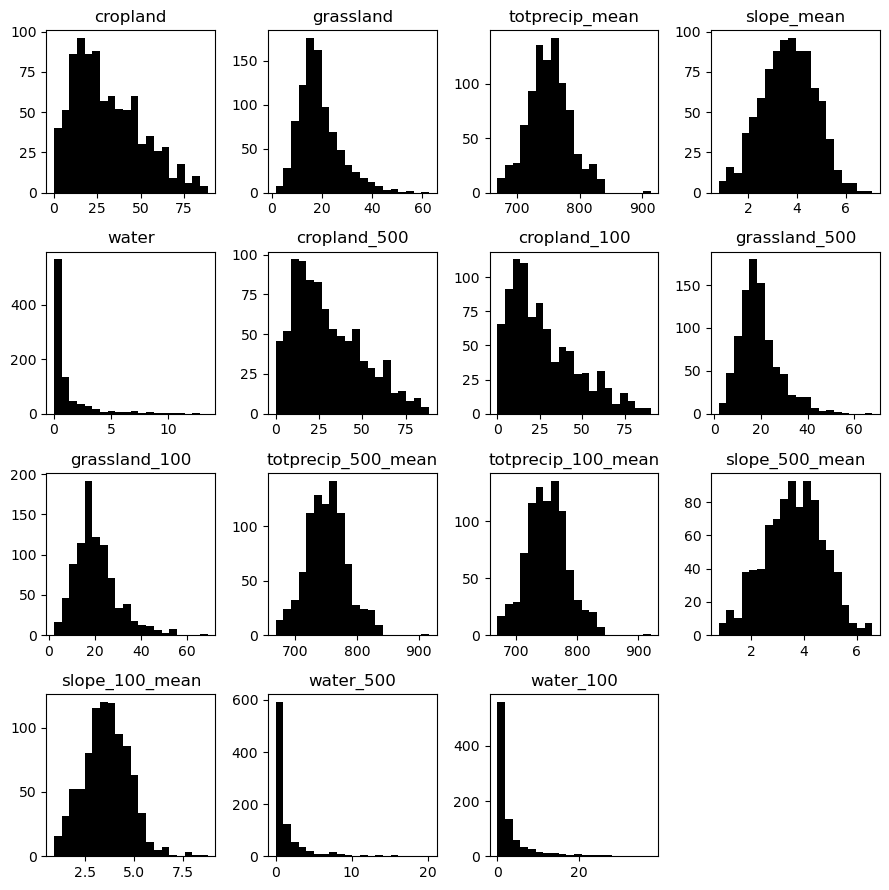

In [30]:
fig = plt.figure(figsize=(9, 9))

# Generate histograms with automatic subplot generation
axs = tn.drop(columns=['X', 'Y', 'value']).hist(
    bins=20,
    grid=False,
    figsize=(9, 9),
    xlabelsize=10,
    ylabelsize=10,
    color='black'
)

# Optional: ensure tight layout so labels fit nicely
plt.tight_layout()

# Save the figure
plt.savefig(f'{figure_folder}\\Figure_S3.pdf', dpi=500)

<Figure size 900x900 with 0 Axes>

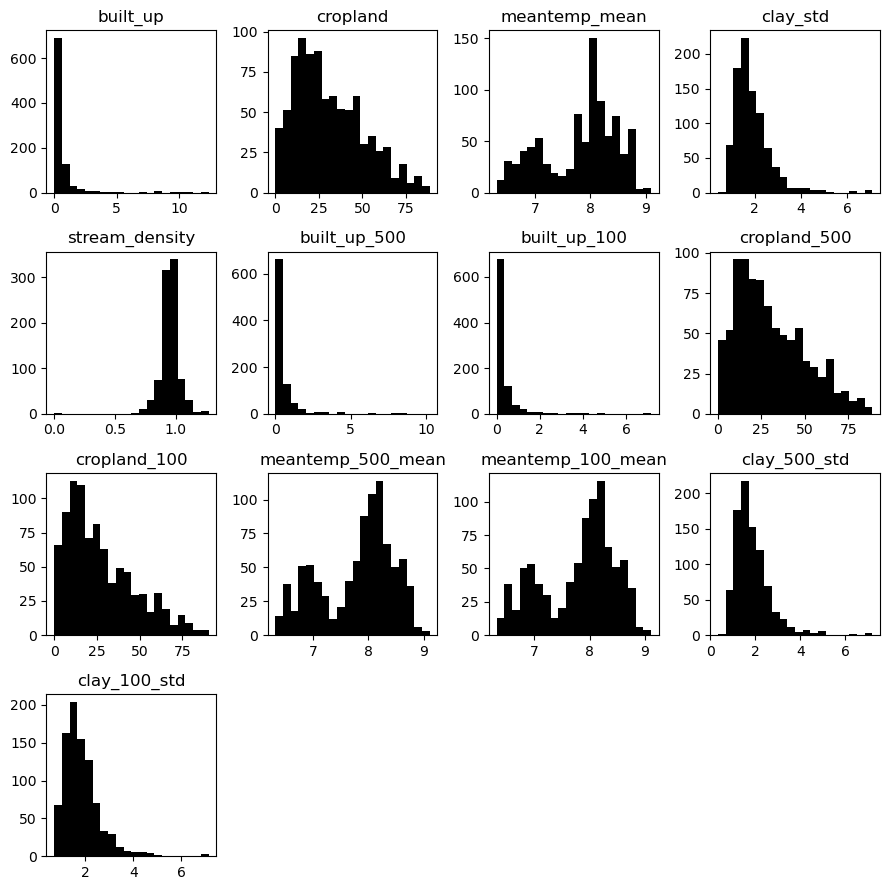

In [31]:
fig = plt.figure(figsize=(9, 9))

# Generate histograms with automatic subplot generation
axs = tp.drop(columns=['X', 'Y', 'value']).hist(
    bins=20,
    grid=False,
    figsize=(9, 9),
    xlabelsize=10,
    ylabelsize=10,
    color='black'
)

# Optional: ensure tight layout so labels fit nicely
plt.tight_layout()

# Save the figure
plt.savefig(f'{figure_folder}\\Figure_S3.pdf', dpi=500)

In [32]:
tn = tn.dropna()

tp = tp.dropna()

In [33]:
len(tn)

892

In [34]:
len(tp)

892

# 4. TN buffer model

In [35]:
buff_tn_model, buff_tn_X_train = model_wq(tn, 'tn', 'buffer', output_folder)

RF model for tn
Splitting data for tn
Covariates used:  cropland, grassland, totprecip_mean, slope_mean, water, cropland_500, cropland_100, grassland_500, grassland_100, totprecip_500_mean, totprecip_100_mean, slope_500_mean, slope_100_mean, water_500, water_100
Tuning hyperparameters for tn
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END ......max_depth=5, n_estimators=50;, score=0.762 total time=   0.2s
[CV 2/5] END ......max_depth=5, n_estimators=50;, score=0.684 total time=   0.2s
[CV 3/5] END ......max_depth=5, n_estimators=50;, score=0.741 total time=   0.2s
[CV 4/5] END ......max_depth=5, n_estimators=50;, score=0.683 total time=   0.2s
[CV 5/5] END ......max_depth=5, n_estimators=50;, score=0.843 total time=   0.2s
[CV 1/5] END ......max_depth=5, n_estimators=60;, score=0.762 total time=   0.3s
[CV 2/5] END ......max_depth=5, n_estimators=60;, score=0.687 total time=   0.4s
[CV 3/5] END ......max_depth=5, n_estimators=60;, score=0.743 total time=   0.

In [36]:
buff_tn_shap_values = calculate_shap(buff_tn_model, buff_tn_X_train)

plot_avg_shap(buff_tn_shap_values, buff_tn_X_train, figure_folder, 'no output')

No figure created


In [37]:
plot_beeswarm_shap(buff_tn_shap_values, buff_tn_X_train, figure_folder, 'tn', 'buffer', 'no output')

No figure created


In [38]:
plot_pdps(buff_tn_model, buff_tn_X_train, figure_folder, 'no output')

No figure created


In [39]:
buff_tn_X_train

,cropland,grassland,totprecip_mean,slope_mean,water,cropland_500,cropland_100,grassland_500,grassland_100,totprecip_500_mean,totprecip_100_mean,slope_500_mean,slope_100_mean,water_500,water_100
0,6.81,11.58,789.0,3.83,0.42,7.16,6.72,12.10,12.77,790.0,790.0,3.88,3.76,0.46,0.34
3,26.62,10.99,760.0,3.12,0.10,25.39,23.50,11.66,12.26,760.0,760.0,3.16,3.03,0.13,0.17
4,17.40,13.94,766.0,3.82,0.30,16.15,13.40,14.48,15.41,766.0,766.0,3.91,3.90,0.38,1.00
6,36.20,13.03,740.0,3.01,0.01,32.72,28.24,13.27,12.65,740.0,740.0,3.13,3.01,0.01,0.01
7,25.21,10.04,713.0,3.39,0.07,20.11,15.29,10.02,9.96,713.0,713.0,3.47,3.46,0.09,0.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,13.33,15.13,767.0,4.97,0.40,12.87,10.73,15.85,16.96,766.0,766.0,4.96,4.82,0.51,1.22
886,18.26,17.53,759.0,3.92,2.35,17.87,15.90,18.17,18.76,759.0,759.0,3.92,3.74,2.70,5.28
887,15.11,27.44,767.0,4.76,3.21,15.24,12.84,28.16,25.16,767.0,767.0,4.76,4.68,4.35,10.02
890,29.45,18.03,785.0,4.28,1.96,25.88,17.08,17.71,16.44,785.0,785.0,4.42,4.60,2.64,5.95


# 5. TP buffer model

In [40]:
buff_tp_model, buff_tp_X_train = model_wq(tp, 'tp', 'buffer', output_folder)

RF model for tp
Splitting data for tp
Covariates used:  built_up, cropland, meantemp_mean, clay_std, stream_density, built_up_500, built_up_100, cropland_500, cropland_100, meantemp_500_mean, meantemp_100_mean, clay_500_std, clay_100_std
Tuning hyperparameters for tp
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END ......max_depth=5, n_estimators=50;, score=0.267 total time=   0.1s
[CV 2/5] END ......max_depth=5, n_estimators=50;, score=0.489 total time=   0.1s
[CV 3/5] END .....max_depth=5, n_estimators=50;, score=-0.496 total time=   0.1s
[CV 4/5] END ......max_depth=5, n_estimators=50;, score=0.261 total time=   0.1s
[CV 5/5] END ......max_depth=5, n_estimators=50;, score=0.224 total time=   0.1s
[CV 1/5] END ......max_depth=5, n_estimators=60;, score=0.235 total time=   0.1s
[CV 2/5] END ......max_depth=5, n_estimators=60;, score=0.460 total time=   0.2s
[CV 3/5] END .....max_depth=5, n_estimators=60;, score=-0.498 total time=   0.2s
[CV 4/5] END ......max

In [41]:
buff_tp_shap_values = calculate_shap(buff_tp_model, buff_tp_X_train)

plot_avg_shap(buff_tp_shap_values, buff_tp_X_train, figure_folder, 'no output')

No figure created


In [42]:
plot_beeswarm_shap(buff_tp_shap_values, buff_tp_X_train, figure_folder, 'tp', 'buffer', 'no output')

No figure created


In [43]:
plot_pdps(buff_tp_model, buff_tp_X_train, figure_folder, 'no output')

No figure created


# 6. Select the most important covariate of the three

In [44]:
best_tn = retrieve_top_buffer(buff_tn_shap_values, buff_tn_X_train)
best_tn

cropland_100      0.769150
grassland_100     0.131301
totprecip_mean    0.104316
slope_mean        0.097800
water_100         0.082901
dtype: float64

In [45]:
buff_tn_X_train

,cropland,grassland,totprecip_mean,slope_mean,water,cropland_500,cropland_100,grassland_500,grassland_100,totprecip_500_mean,totprecip_100_mean,slope_500_mean,slope_100_mean,water_500,water_100
0,6.81,11.58,789.0,3.83,0.42,7.16,6.72,12.10,12.77,790.0,790.0,3.88,3.76,0.46,0.34
3,26.62,10.99,760.0,3.12,0.10,25.39,23.50,11.66,12.26,760.0,760.0,3.16,3.03,0.13,0.17
4,17.40,13.94,766.0,3.82,0.30,16.15,13.40,14.48,15.41,766.0,766.0,3.91,3.90,0.38,1.00
6,36.20,13.03,740.0,3.01,0.01,32.72,28.24,13.27,12.65,740.0,740.0,3.13,3.01,0.01,0.01
7,25.21,10.04,713.0,3.39,0.07,20.11,15.29,10.02,9.96,713.0,713.0,3.47,3.46,0.09,0.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,13.33,15.13,767.0,4.97,0.40,12.87,10.73,15.85,16.96,766.0,766.0,4.96,4.82,0.51,1.22
886,18.26,17.53,759.0,3.92,2.35,17.87,15.90,18.17,18.76,759.0,759.0,3.92,3.74,2.70,5.28
887,15.11,27.44,767.0,4.76,3.21,15.24,12.84,28.16,25.16,767.0,767.0,4.76,4.68,4.35,10.02
890,29.45,18.03,785.0,4.28,1.96,25.88,17.08,17.71,16.44,785.0,785.0,4.42,4.60,2.64,5.95


In [46]:
tn

,site_id,value,X,Y,cropland,grassland,totprecip_mean,slope_mean,water,cropland_500,cropland_100,grassland_500,grassland_100,totprecip_500_mean,totprecip_100_mean,slope_500_mean,slope_100_mean,water_500,water_100
0,ee_SJA0088000,1.39,6.460567e+06,536966.995615,6.81,11.58,789.0,3.83,0.42,7.16,6.72,12.10,12.77,790.0,790.0,3.88,3.76,0.46,0.34
1,ee_SJA0106000,5.28,6.499463e+06,611096.533002,35.75,17.33,713.0,3.14,0.16,29.03,14.32,20.43,21.99,712.0,712.0,3.37,3.55,0.22,0.81
2,ee_SJA0112000,1.27,6.443129e+06,585488.041664,28.81,20.50,759.0,3.90,0.31,26.72,18.08,21.30,18.01,759.0,759.0,3.90,4.62,0.44,1.41
3,ee_SJA0135000,4.47,6.565404e+06,582794.408882,26.62,10.99,760.0,3.12,0.10,25.39,23.50,11.66,12.26,760.0,760.0,3.16,3.03,0.13,0.17
4,ee_SJA0148000,1.90,6.472192e+06,529013.514162,17.40,13.94,766.0,3.82,0.30,16.15,13.40,14.48,15.41,766.0,766.0,3.91,3.90,0.38,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,lv_92,1.57,6.310550e+06,413147.668799,26.67,20.79,743.0,4.07,0.15,25.79,19.27,21.97,24.13,743.0,744.0,4.08,4.64,0.20,0.56
889,lv_94,1.70,6.319852e+06,416381.110931,29.71,20.71,742.0,3.95,0.18,27.86,20.37,21.82,23.59,742.0,742.0,4.00,4.67,0.23,0.50
890,lv_95,1.66,6.192672e+06,710175.286098,29.45,18.03,785.0,4.28,1.96,25.88,17.08,17.71,16.44,785.0,785.0,4.42,4.60,2.64,5.95
891,lv_97,1.09,6.380848e+06,372416.139786,7.12,15.02,736.0,4.64,2.59,7.31,7.06,15.88,17.90,736.0,736.0,4.62,4.49,3.16,5.72


In [47]:
buff_tn_d = tn[best_tn.index.tolist()]

In [48]:
buff_tn_d 

,cropland_100,grassland_100,totprecip_mean,slope_mean,water_100
0,6.72,12.77,789.0,3.83,0.34
1,14.32,21.99,713.0,3.14,0.81
2,18.08,18.01,759.0,3.90,1.41
3,23.50,12.26,760.0,3.12,0.17
4,13.40,15.41,766.0,3.82,1.00
...,...,...,...,...,...
888,19.27,24.13,743.0,4.07,0.56
889,20.37,23.59,742.0,3.95,0.50
890,17.08,16.44,785.0,4.28,5.95
891,7.06,17.90,736.0,4.64,5.72


In [49]:
# glue back the predictor df
buff_tn_d = buff_tn_d.copy()

buff_tn_d ['value'] = tn['value']
buff_tn_d ['site_id'] = tn['site_id']
buff_tn_d ['X'] = tn['X']
buff_tn_d ['Y'] = tn['Y']

In [50]:
best_tp = retrieve_top_buffer(buff_tp_shap_values, buff_tp_X_train)
best_tp

built_up_500         0.024736
cropland             0.008284
meantemp_500_mean    0.006885
clay_100_std         0.003530
stream_density       0.002911
dtype: float64

In [51]:
buff_tp_d  = tp[best_tp.index.tolist()]

In [52]:
buff_tp_d = buff_tp_d.copy()

buff_tp_d['value'] = tp['value']
buff_tp_d['site_id'] = tp['site_id']
buff_tp_d['X'] = tp['X']
buff_tp_d['Y'] = tp['Y']

# 7. TN Top 5 buffer

In [53]:
top5_buff_tn_model, top5_buff_tn_X_train = model_wq(buff_tn_d , 'tn', 'top5_buffer', output_folder)

RF model for tn
Splitting data for tn
Covariates used:  cropland_100, grassland_100, totprecip_mean, slope_mean, water_100
Tuning hyperparameters for tn
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END ......max_depth=5, n_estimators=50;, score=0.746 total time=   0.0s
[CV 2/5] END ......max_depth=5, n_estimators=50;, score=0.694 total time=   0.0s
[CV 3/5] END ......max_depth=5, n_estimators=50;, score=0.730 total time=   0.0s
[CV 4/5] END ......max_depth=5, n_estimators=50;, score=0.699 total time=   0.0s
[CV 5/5] END ......max_depth=5, n_estimators=50;, score=0.832 total time=   0.0s
[CV 1/5] END ......max_depth=5, n_estimators=60;, score=0.746 total time=   0.1s
[CV 2/5] END ......max_depth=5, n_estimators=60;, score=0.693 total time=   0.1s
[CV 3/5] END ......max_depth=5, n_estimators=60;, score=0.730 total time=   0.0s
[CV 4/5] END ......max_depth=5, n_estimators=60;, score=0.697 total time=   0.0s
[CV 5/5] END ......max_depth=5, n_estimators=60;, score=

In [54]:
top5_buff_tn_shap_values = calculate_shap(top5_buff_tn_model, top5_buff_tn_X_train)

plot_avg_shap(top5_buff_tn_shap_values, top5_buff_tn_X_train, figure_folder, 'no output')

No figure created


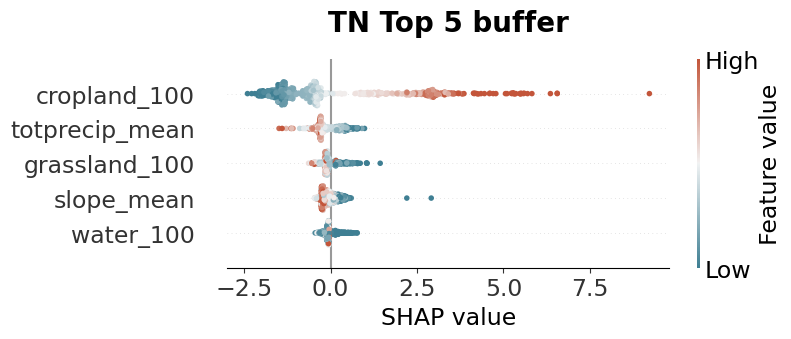

In [55]:
plot_beeswarm_shap(top5_buff_tn_shap_values, top5_buff_tn_X_train, figure_folder, 'tn', 'top5_buffer', 'Figure_6e')

In [56]:
plot_pdps(top5_buff_tn_model, top5_buff_tn_X_train, figure_folder, 'no output')

No figure created


# 8. TP Top 5 buffer model

In [57]:
top5_buff_tp_model, top5_buff_tp_X_train = model_wq(buff_tp_d , 'tp', 'top5_buffer', output_folder)

RF model for tp
Splitting data for tp
Covariates used:  built_up_500, cropland, meantemp_500_mean, clay_100_std, stream_density
Tuning hyperparameters for tp
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END ......max_depth=5, n_estimators=50;, score=0.197 total time=   0.0s
[CV 2/5] END ......max_depth=5, n_estimators=50;, score=0.421 total time=   0.0s
[CV 3/5] END .....max_depth=5, n_estimators=50;, score=-0.212 total time=   0.0s
[CV 4/5] END ......max_depth=5, n_estimators=50;, score=0.271 total time=   0.0s
[CV 5/5] END ......max_depth=5, n_estimators=50;, score=0.042 total time=   0.0s
[CV 1/5] END ......max_depth=5, n_estimators=60;, score=0.195 total time=   0.0s
[CV 2/5] END ......max_depth=5, n_estimators=60;, score=0.403 total time=   0.0s
[CV 3/5] END .....max_depth=5, n_estimators=60;, score=-0.167 total time=   0.0s
[CV 4/5] END ......max_depth=5, n_estimators=60;, score=0.254 total time=   0.0s
[CV 5/5] END ......max_depth=5, n_estimators=60;, s

In [58]:
top5_buff_tp_shap_values = calculate_shap(top5_buff_tp_model, top5_buff_tp_X_train)

plot_avg_shap(top5_buff_tp_shap_values, top5_buff_tp_X_train, figure_folder, 'no output')

No figure created


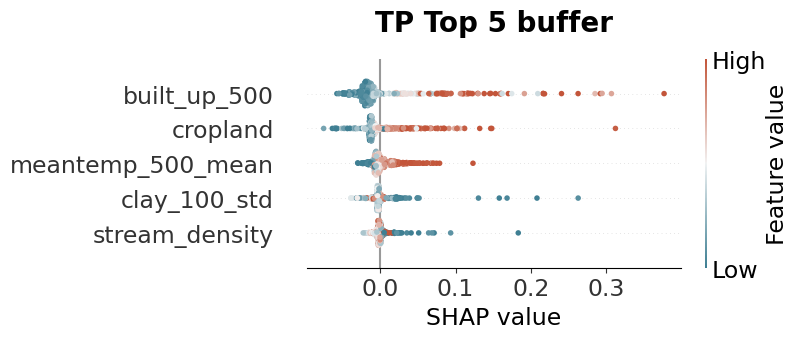

In [59]:
plot_beeswarm_shap(top5_buff_tp_shap_values, top5_buff_tp_X_train, figure_folder, 'tp', 'top5_buffer', 'Figure_6f')

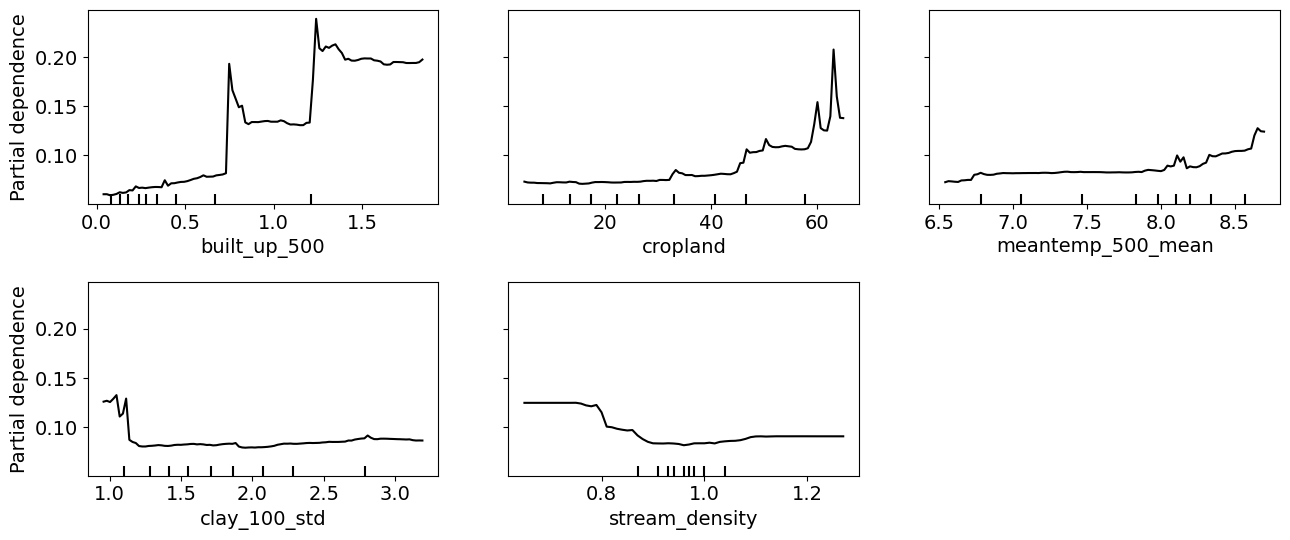

In [60]:
plot_pdps(top5_buff_tp_model, top5_buff_tp_X_train, figure_folder, 'Figure_7')